In [59]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [60]:
from fastai.text import *

In [61]:
INPUT_FILE = 'twitter-airline-sentiment/Tweets.csv'
MODEL_PATH = 'data/model2'

raw_data = pd.read_csv(INPUT_FILE, header=0)
df = raw_data.copy()[['text', 'airline_sentiment']]
df = df.rename(columns={'airline_sentiment': 'sentiment'})
df_labeled = df[df.sentiment != 'neutral']

print("DATA SIZE: " + str(df.shape))
df.head()

DATA SIZE: (14640, 2)


,text,sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [62]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.1, random_state=0)

print("Training: %d; test: %d" % (len(train_df), len(valid_df)))

Training: 13176; test: 1464


In [70]:
df['text'][:10]

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
5    @VirginAmerica seriously would pay $30 a fligh...
6    @VirginAmerica yes, nearly every time I fly VX...
7    @VirginAmerica Really missed a prime opportuni...
8      @virginamerica Well, I didn't…but NOW I DO! :-D
9    @VirginAmerica it was amazing, and arrived an ...
Name: text, dtype: object

In [64]:
data_lm = TextLMDataBunch.from_df(MODEL_PATH, train_df=train_df, valid_df=valid_df, text_cols='text')

In [65]:
data_lm.show_batch()

idx,text
0,"you hung up on me again . xxbos @united you left my bag in xxmaj houston last night . xxmaj it 's freezing cold in xxmaj memphis . xxmaj any idea on when i will see it ? xxmaj off again tomorrow . xxbos @virginamerica , you 're doing a great job adding little luxuries / xxunk that improve the air travel experience . xxmaj thank you . xxmaj keep"
1,"home xxunk snow & & xxmaj cancelled xxmaj flightlations ; delivered bag w / o hassle ; plus no wait on phone & & an upgrade . xxmaj thank you ! xxbos @southwestair are you hiring for flight attendants right now xxbos @southwestair my son is flying xxmaj south xxmaj west from xxup nola - xxmaj orlando , hope to enter for him to win this contest # destinationdragons xxbos"
2,"an employee at the gate 15min before boarding like u expect ur customers to . xxmaj be a competent company like ur xxunk xxbos @united xxmaj flight 683 last night was # xxunk . xxmaj will be a long time before i recommend xxmaj united to anyone . xxbos @usairways xxup clt , please send more than one cust svc rep to your cust svc counter to assist a line"
3,". xxmaj better yet , you xxunk out of xxmaj flight xxmaj booking xxmaj problems rooms for people claiming weather http : / / t.co / xxunk xxbos @usairways @claudoakeshott how about a link that works pls xxmaj nothing but complete frustration w usair last 12 hrs xxbos @jetblue too xxmaj late xxmaj flight . xxmaj several passengers are xxunk . xxmaj you 're in xxunk with big alcohol ."
4,until tomorrow . xxmaj you wo n't put xxbos @americanair he is at the xxmaj boston airport . xxmaj there is a problem . xxmaj the agents will not honor the voucher because one number is xxunk out . xxbos @united - i really down think downgrading the booze / food xxunk at the club is a good way to go . xxmaj how about you look @aircanada ? xxbos


In [66]:
train_df.head(30)

,text,sentiment
5909,@SouthwestAir Thank you. Great tool,positive
13662,@AmericanAir working over time tonight? Got d...,negative
12405,@AmericanAir Delayed: AA3186 - Missed due to d...,negative
2528,@united while busy on his cell phone ???,negative
2043,@united you hung up on me again.,negative
1761,@united you left my bag in Houston last night....,negative
258,"@VirginAmerica, you're doing a great job addin...",positive
7574,@JetBlue then this agent demanded I remove my ...,negative
5094,"@SouthwestAir - wow! 100 minutes on hold, so f...",negative
7814,@JetBlue Hello! Can you tell me if you current...,neutral


In [8]:
data_lm.save('lm_raw01.pkl')

In [9]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


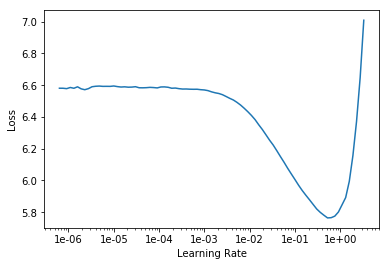

In [11]:
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(4, 0.5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.661923,6.492567,0.130729,00:12
1,6.409523,5.697910,0.182689,00:12
2,5.337045,4.511212,0.225570,00:12
3,4.589779,4.294363,0.241022,00:12


In [15]:
learn.save('fit_head')

In [16]:
learn.load('fit_head');

In [17]:
learn.unfreeze()

In [18]:
learn.fit_one_cycle(10, 0.05, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.203342,4.163437,0.247941,00:16
1,4.200113,4.154933,0.246181,00:16
2,4.166948,4.186334,0.232093,00:17
3,4.058502,4.039674,0.258482,00:17
4,4.056991,4.020502,0.263095,00:17
5,3.842626,3.955804,0.266766,00:17
6,3.644510,3.944552,0.274826,00:17
7,3.423489,3.978751,0.277629,00:17
8,3.183551,4.030739,0.278919,00:17
9,3.004767,4.079695,0.277679,00:17


In [19]:
learn.save('fine_tuned')

In [20]:
learn.load('fine_tuned');

In [21]:
TEXT = "My flight was"
N_WORDS = 40
N_SENTENCES = 2

In [22]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

My flight was delayed three hours . Just told to call me back back to United ASAP . Plane is a long day xxbos @jetblue No i have to use the same day of my vacation was given
My flight was Cancelled Flightled , no one at all . Not what a single apology xxbos @usairways My bag is lost and i would not let my head in MDW . Just told not .


In [23]:
learn.save_encoder('fine_tuned_enc')

### Classifier

In [24]:
train_df_l, valid_df_l = train_test_split(df_labeled, test_size=0.1, random_state=0)

print("Training: %d; test: %d" % (len(train_df_l), len(valid_df_l)))

Training: 10386; test: 1155


In [25]:
class_counts = train_df_l.groupby('sentiment').count()
class_counts

,text
sentiment,
negative,8254
positive,2132


In [32]:
data_clas = TextClasDataBunch.from_df(INPUT_PATH, train_df=train_df_l, valid_df=valid_df_l, 
                                      text_cols='text', label_cols='sentiment', vocab=data_lm.vocab)

In [33]:
data_clas.show_batch()

text,target
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj xxunk xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @usairways e xxrep 4 y ! xxmaj cancelled xxmaj flightlations , xxmaj flight xxmaj booking xxmaj problemss , reflight xxmaj booking xxmaj problemss , but y' all got me on the same flight out tonight ( not tomorrow ) & & the xxup fc upgrade . xxmaj thx !",positive
"xxbos @usairways 4 segments , 4 / 4 delayed . xxmaj gnv > xxup ctl . xxup ctl > xxup jan . xxup jan > xxup ctl . xxup ctl > xxup gnv . xxmaj my year off from flying with you guys was the way to go .",negative
xxbos @united - xxup seriously it 's 2015 ? ! ? ! xxup no wifi on a 5hr flight from xxup cle - xxup sfo # 1589 . xxmaj you 're the xxup only airline w / out wifi ... and pls no ' xxunk ' xxup bs .,negative
xxbos @united xxunk 7 xxup weeks xxmaj late flightr xxup and i xxup still xxup have xxup not xxup received xxup my xxup miles xxup from xxup the mileageplus xxmaj gift xxmaj card $ 150 xxup xxunk xxup card i xxup handed xxup over ! ! !,negative


In [34]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


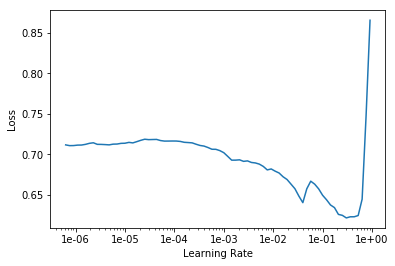

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(1, 0.3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.524060,0.362722,0.826840,00:06


In [38]:
learn.save('first')

In [40]:
learn.load('first');

In [41]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(0.1/(2.6**4),0.1), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.367298,0.543650,0.876190,00:07


In [42]:
learn.save('second')

In [43]:
learn.load('second');

In [44]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-2/(2.6**4),5e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.424468,0.349188,0.846753,00:12


In [45]:
learn.save('third')

In [46]:
learn.save('load');

In [47]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.380528,0.292650,0.867532,00:16
1,0.328562,0.291261,0.872727,00:15


In [57]:
learn.predict("Awful flight")

(Category negative, tensor(0), tensor([0.8365, 0.1635]))

In [49]:
learn.predict("Great trip, thanks to all")

(Category positive, tensor(1), tensor([0.1170, 0.8830]))

In [58]:
learn.predict("The attendant was very rude!")

(Category negative, tensor(0), tensor([0.8660, 0.1340]))